<div style="background-color: #007bff; text-align: center; color: #f0f0f0; padding: 10px;">
    
# Hand Gesture Recognition

</div>


## Downloading the dataset in colab

In [2]:
#Setting up the Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d gti-upm/leapgestrecog

 99% 2.12G/2.13G [00:23<00:00, 122MB/s]
100% 2.13G/2.13G [00:23<00:00, 95.9MB/s]


In [1]:
!unzip /content/leapgestrecog.zip

## Importing libraries

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

## Reading images

In [7]:
dir = '/content/leapGestRecog'

In [9]:
# Getting the paths of the images
images = []
labels = []
for directory in os.listdir(dir):
  for subDir in os.listdir(os.path.join(dir,directory)):
    for img in os.listdir(os.path.join(dir, directory, subDir)):
      img_path = os.path.join(dir, directory, subDir, img)
      images.append(img_path)
      labels.append(subDir)

## Creating the Dataframe

In [14]:
Images = pd.Series(images, name="Images")
Labels = pd.Series(labels, name="labels")
hand_gesture_data = pd.concat([Images, Labels], axis=1)
hand_gesture_df = pd.DataFrame(hand_gesture_data)
hand_gesture_df.head()

,Images,labels
0,/content/leapGestRecog/00/05_thumb/frame_00_05...,05_thumb
1,/content/leapGestRecog/00/05_thumb/frame_00_05...,05_thumb
2,/content/leapGestRecog/00/05_thumb/frame_00_05...,05_thumb
3,/content/leapGestRecog/00/05_thumb/frame_00_05...,05_thumb
4,/content/leapGestRecog/00/05_thumb/frame_00_05...,05_thumb


#### Count of Images per class

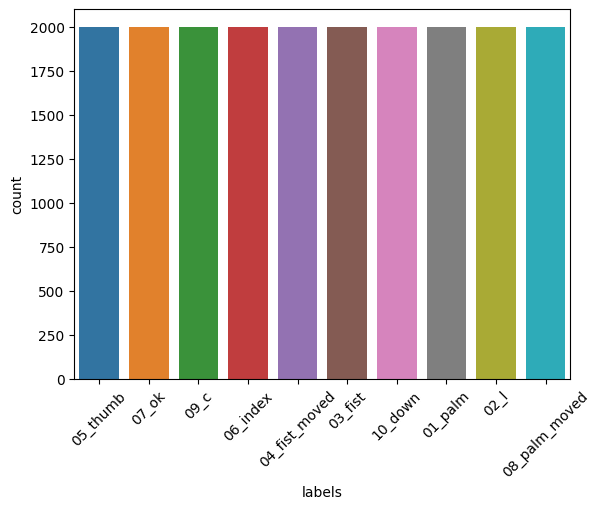

In [23]:
sns.countplot(data = hand_gesture_df, x = 'labels', hue = 'labels')
plt.xticks(rotation = 45);

**Plot Insight**
- We have 2000 images for every hand gestures class.

## Splitting the dataset into train and test

In [25]:
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(hand_gesture_df, test_size=0.3, random_state=42)

## Data Preprocessing

In [26]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="Images",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= X_test,x_col="Images", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="Images", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )


Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [27]:
# Printing the classes
classes = list(train.class_indices.keys())
print (classes)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


## Data visualization

In [28]:
def show_hand_gesture(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

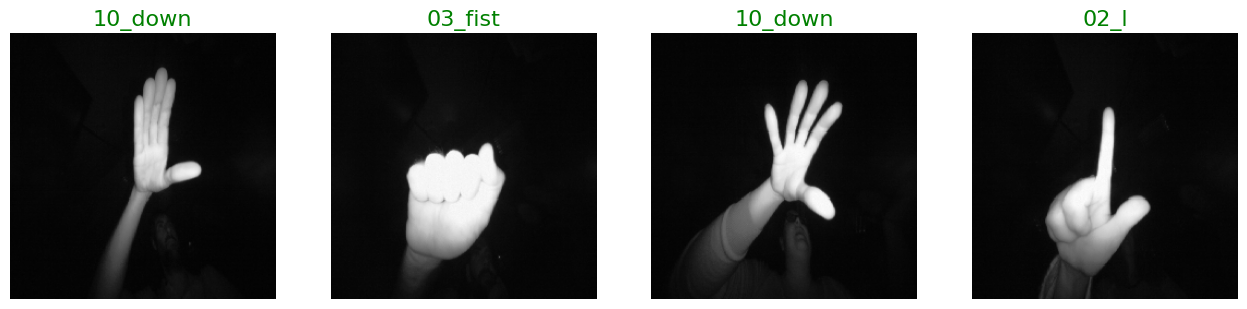

In [29]:
show_hand_gesture(train)

## Model Building

In [30]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

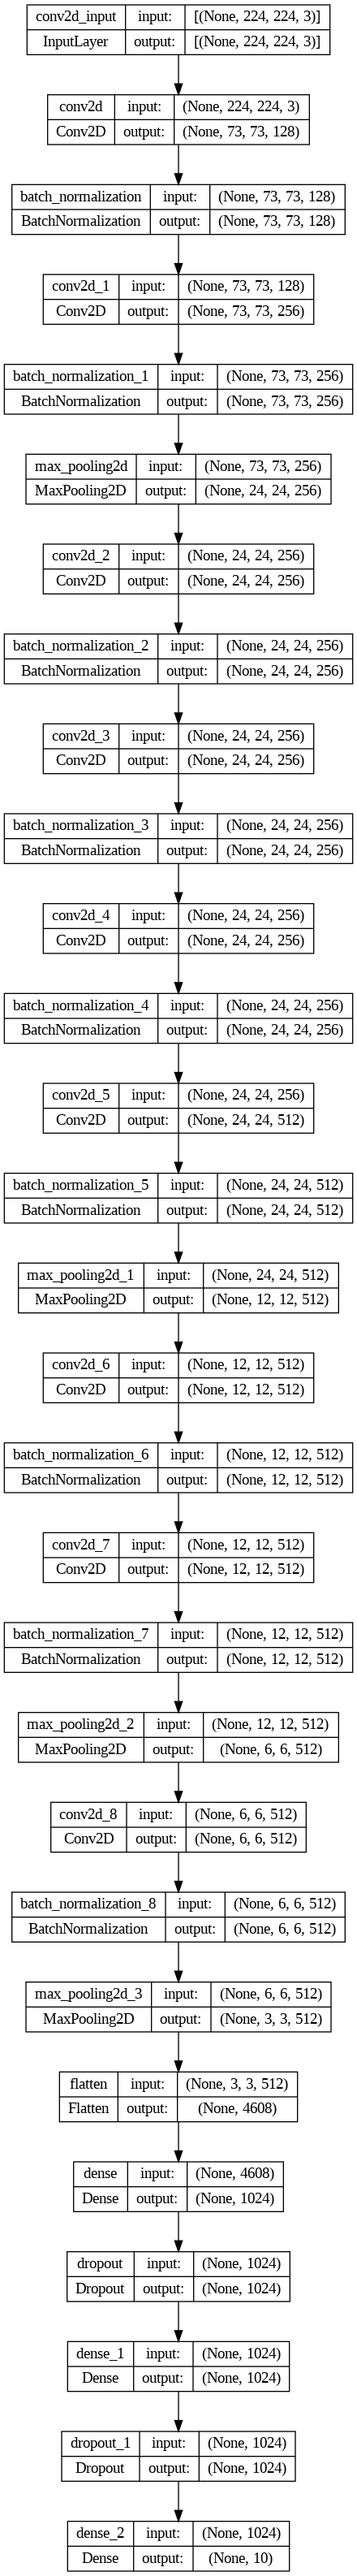

In [31]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Model Training

In [32]:
history = model.fit(train, epochs=3, validation_data=val, verbose=1)

Epoch 1/3
3500/3500 [==============================] - 215s 59ms/step - loss: 0.5070 - accuracy: 0.8456 - val_loss: 0.0073 - val_accuracy: 0.9980
Epoch 2/3
3500/3500 [==============================] - 201s 58ms/step - loss: 0.0287 - accuracy: 0.9920 - val_loss: 0.0017 - val_accuracy: 0.9992
Epoch 3/3
3500/3500 [==============================] - 201s 58ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 6.5899e-04 - val_accuracy: 0.9998


## Model Testing

In [33]:
model.evaluate(test, verbose=1)

1000/1000 [==============================] - 20s 20ms/step - loss: 7.2280e-04 - accuracy: 0.9998


[0.0007227956084534526, 0.999750018119812]

## Saving my model

In [34]:
model.save("hand_gesture_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Getting Results

In [35]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1000/1000 [==============================] - 26s 25ms/step


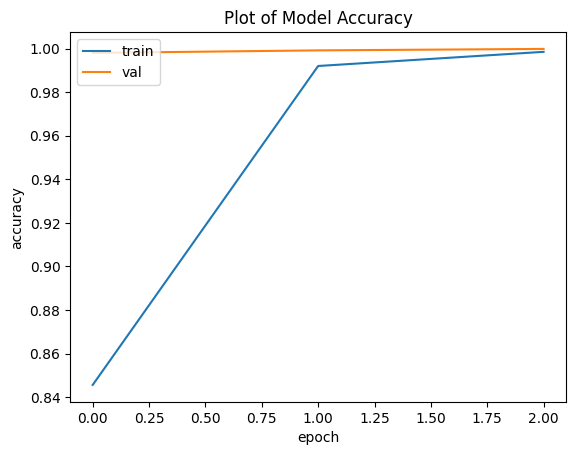

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot of Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Plot Insights**

- Here we can see an increase in the accuracy with increase in the number of epoch.

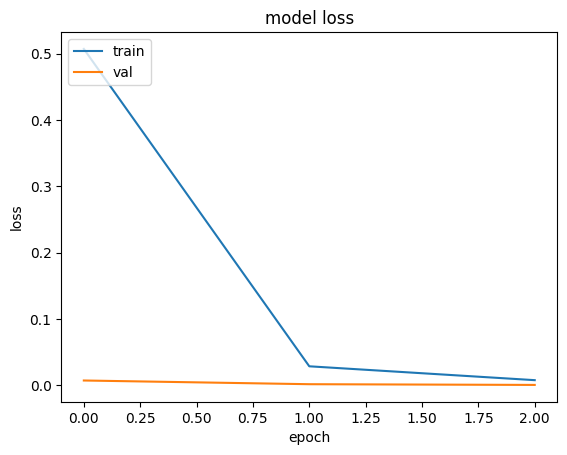

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Plot Insights**

- Here we can see an decrease in the accuracy with increase in the number of epoch.

## Evaluation Metrics

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

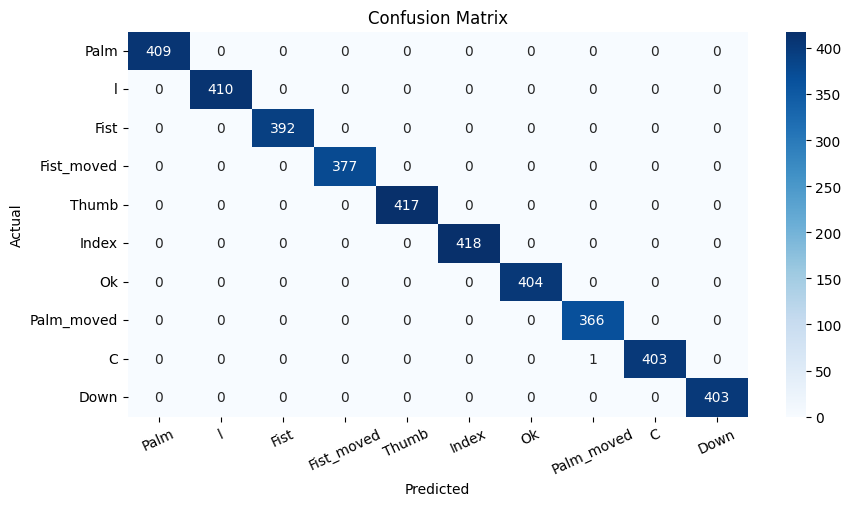

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Palm', 'l', 'Fist', 'Fist_moved', 'Thumb', 'Index', 'Ok', 'Palm_moved', 'C', 'Down']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=25)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [45]:
y_test = X_test.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       409
         02_l       1.00      1.00      1.00       410
      03_fist       1.00      1.00      1.00       392
04_fist_moved       1.00      1.00      1.00       377
     05_thumb       1.00      1.00      1.00       417
     06_index       1.00      1.00      1.00       418
        07_ok       1.00      1.00      1.00       404
08_palm_moved       1.00      1.00      1.00       366
         09_c       1.00      1.00      1.00       404
      10_down       1.00      1.00      1.00       403

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

Accuracy of the Model: 100.0%


**Data Insights**

- We have obtained an accuracy of 100% for our recognition model.

## **Conclusion**



The developed image recognition model achieved outstanding performance with 100% accuracy across various hand gesture classes. The model effectively learned to distinguish between different hand gestures like palm, fist, thumb, and others, with high precision and recall. This demonstrates the capability of the model to accurately identify and classify hand gestures based on input images, showcasing its reliability and effectiveness for real-world applications.